<h1 align="center" style="color:#6699ff"> DataCamp IEEE Fraud Detection </h1>

<img src="https://github.com/DataCampM2DSSAF/suivi-du-data-camp-equipe-tchouacheu-niang-chokki/blob/master/img/credit-card-fraud-detection.png?raw=true" width="800" align="center">

#  <a style="color:#6699ff"> Team </a>
- <a style="color:#6699ff">Mohamed NIANG </a>
- <a style="color:#6699ff">Fernanda Tchouacheu </a>
- <a style="color:#6699ff">Hypolite Chokki </a>

# <a style="color:#6699ff">  Table of Contents</a> 

<a style="color:#6699ff"> I. Reduce Memory Usage for Big Data</a>

<a style="color:#6699ff"> II. Load Data</a>

<a style="color:#6699ff"> III. Run LGBM Classifier with Cross Validation</a>

**Import package**

In [1]:
# General imports
import numpy as np
import pandas as pd
import os, sys, gc, warnings, random, datetime

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold, GroupKFold
from sklearn.preprocessing import LabelEncoder

import lightgbm as lgb
from tqdm import tqdm

import math
warnings.filterwarnings('ignore')

os.chdir('/kaggle/input/ieeefewithpreprocessing') # Set working directory
print(os.listdir('/kaggle/input/ieeefewithpreprocessing'))

['remove_features.pkl', 'sample_submission.csv', 'test_df.pkl', 'train_df.pkl']


# <a style="color:#6699ff"> I. Reduce Memory Usage for Big Data</a>

In [2]:
# Helpers

# Seeder
# :seed to make all processes deterministic     # type: int
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
# Memory Reducer
# :df pandas dataframe to reduce size             # type: pd.DataFrame()
# :verbose                                        # type: bool
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# <a style="color:#6699ff"> II. Load Data</a>

In [3]:
# Data Load

train_df = reduce_mem_usage(pd.read_pickle('train_df.pkl'))
test_df = reduce_mem_usage(pd.read_pickle('test_df.pkl'))

remove_features = pd.read_pickle('remove_features.pkl')
remove_features = list(remove_features['features_to_remove'].values)

print('Load Data')
print('Shape control:', train_df.shape, test_df.shape)

Mem. usage decreased to 1278.41 Mb (41.3% reduction)
Mem. usage decreased to 1104.71 Mb (41.1% reduction)
Load Data
Shape control: (590540, 791) (506691, 791)


# <a style="color:#6699ff"> III. Run LGBM Classifier with Cross Validation</a>

In [4]:
# Vars
SEED = 42
seed_everything(SEED)
target = 'isFraud'
N_SPLITS = 5
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')

In [5]:
# Model params
lgb_params = {
                    'objective':'binary',
                    'boosting_type':'gbdt',
                    'metric':'auc',
                    'n_jobs':-1,
                    'learning_rate':0.01,
                    'num_leaves': 2**8,
                    'max_depth':-1,
                    'tree_learner':'serial',
                    'colsample_bytree': 0.7,
                    'subsample_freq':1,
                    'subsample':0.7,
                    'n_estimators':20000,
                    'max_bin':255,
                    'verbose':-1,
                    'seed': SEED,
                    'early_stopping_rounds':100, 
                } 

In [6]:
# Final features list
features_columns = [col for col in list(train_df) if col not in remove_features]

## LGBM classifier with cross validation

In [7]:
# Model Train
   
folds = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

X,y = train_df[features_columns], train_df[target]    
P = test_df[features_columns]  

predictions = np.zeros(len(test_df))
oof = np.zeros(len(train_df))

In [8]:
del train_df, test_df, features_columns
gc.collect()

0

In [9]:
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y)):
    print('Fold:',fold_+1)
    tr_x, tr_y = X.iloc[trn_idx,:], y[trn_idx]
    vl_x, vl_y = X.iloc[val_idx,:], y[val_idx]
            
    print(len(tr_x),len(vl_x))
    tr_data = lgb.Dataset(tr_x, label=tr_y)
    vl_data = lgb.Dataset(vl_x, label=vl_y)  

    estimator = lgb.train(
        lgb_params,
        tr_data,
        valid_sets = [tr_data, vl_data],
        verbose_eval = 1000,
    )   
        
    pp_p = estimator.predict(P)
    predictions += pp_p/N_SPLITS
        
    oof_preds = estimator.predict(vl_x)
    oof[val_idx] = (oof_preds - oof_preds.min())/(oof_preds.max() - oof_preds.min())
        
    del tr_x, tr_y, vl_x, vl_y, tr_data, vl_data
    gc.collect()

Fold: 1
472432 118108
Training until validation scores don't improve for 100 rounds
[1000]	training's auc: 0.99995	valid_1's auc: 0.975296
[2000]	training's auc: 1	valid_1's auc: 0.978083
Early stopping, best iteration is:
[2440]	training's auc: 1	valid_1's auc: 0.978408
Fold: 2
472432 118108
Training until validation scores don't improve for 100 rounds
[1000]	training's auc: 0.999947	valid_1's auc: 0.97579
[2000]	training's auc: 1	valid_1's auc: 0.97875
Early stopping, best iteration is:
[2532]	training's auc: 1	valid_1's auc: 0.979032
Fold: 3
472432 118108
Training until validation scores don't improve for 100 rounds
[1000]	training's auc: 0.999948	valid_1's auc: 0.974991
[2000]	training's auc: 1	valid_1's auc: 0.977551
Early stopping, best iteration is:
[2239]	training's auc: 1	valid_1's auc: 0.977722
Fold: 4
472432 118108
Training until validation scores don't improve for 100 rounds
[1000]	training's auc: 0.999951	valid_1's auc: 0.972903
[2000]	training's auc: 1	valid_1's auc: 0.97

In [10]:
print('OOF AUC:', metrics.roc_auc_score(y, oof))

OOF AUC: 0.9768803636902861


In [11]:
print(metrics.confusion_matrix(y, oof.round()))

[[569493    384]
 [  6162  14501]]


In [12]:
print(metrics.classification_report(y, oof.round()))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    569877
           1       0.97      0.70      0.82     20663

    accuracy                           0.99    590540
   macro avg       0.98      0.85      0.91    590540
weighted avg       0.99      0.99      0.99    590540



**Feature importance for LGBM with cross validation**

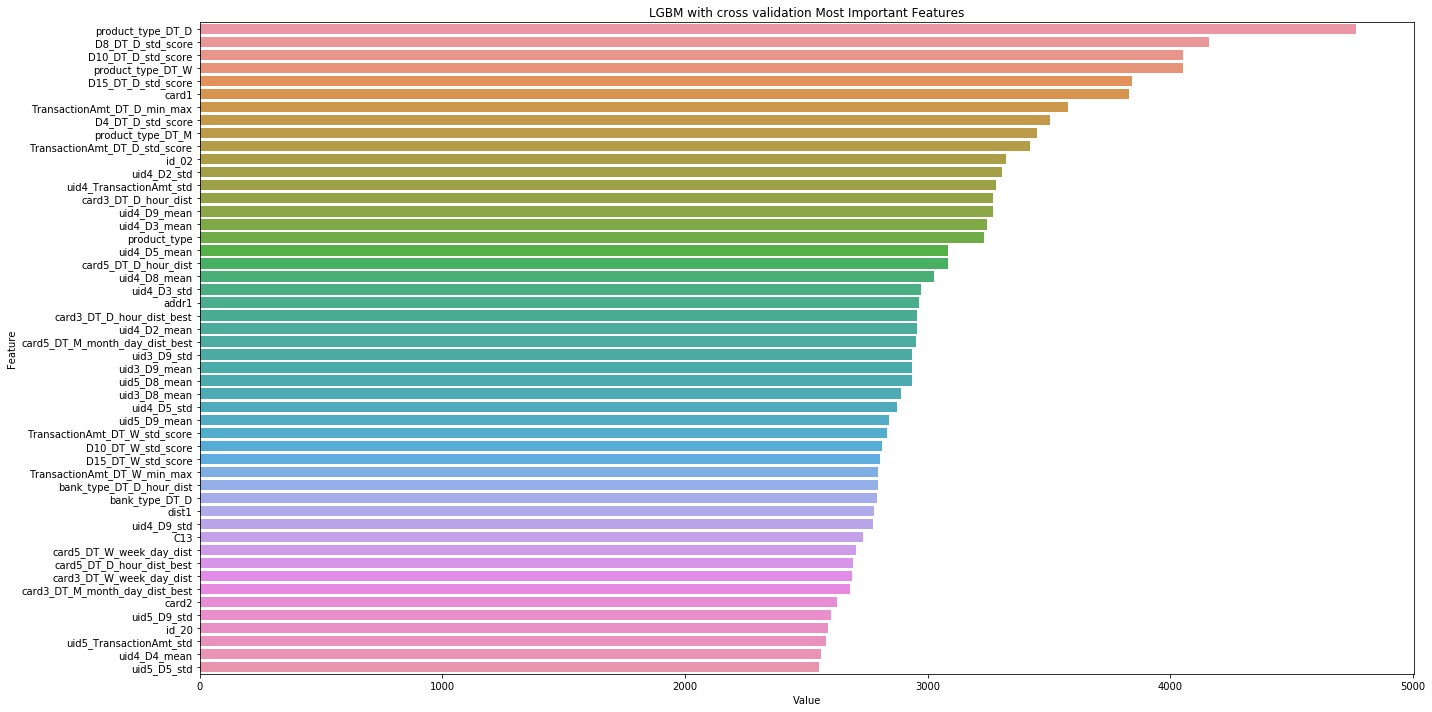

In [13]:
feature_imp = pd.DataFrame(sorted(zip(estimator.feature_importance(),X.columns)), columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:50])
plt.title('LGBM with cross validation Most Important Features')
plt.tight_layout()
plt.show()

**Eleventh submission for LGBM with cross validation**

In [14]:
submission = pd.read_csv('sample_submission.csv', index_col='TransactionID')
submission.isFraud = predictions
submission.head()

,isFraud
TransactionID,
3663549,0.000101
3663550,0.000420
3663551,0.000149
3663552,0.000135
3663553,0.000185


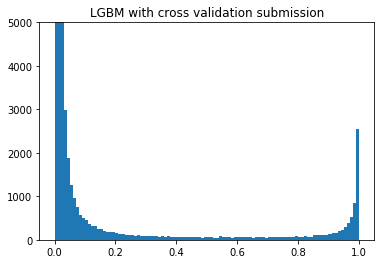

In [15]:
plt.hist(submission.isFraud,bins=100)
plt.ylim((0,5000))
plt.title('LGBM with cross validation submission')
plt.show()

In [16]:
submission.to_csv('/kaggle/working/lgbm_cv_submission.csv')